# Prediksi Total Pengeluaran Berdasarkan Transaksi Pembelian
Proyek Machine Learning untuk submission kelas Dicoding: Machine Learning

**Pendekatan**: Regresi
**Target**: TotalCost

## 1. Pendahuluan
Dalam pengelolaan anggaran perusahaan, penting untuk memahami faktor-faktor yang memengaruhi total pengeluaran dari tiap transaksi. Dengan prediksi yang akurat, perusahaan dapat mengelola anggaran dan negosiasi dengan supplier secara lebih efisien.

## 2. Problem Domain
- **Masalah**: Prediksi total biaya pembelian (`TotalCost`) berdasarkan data transaksi.
- **Solusi**: Model regresi untuk memprediksi nilai `TotalCost`.
- **Manfaat**: Menyediakan insight terhadap pengeluaran berdasarkan jenis barang, supplier, dan pembeli.

## 3. Data Understanding
Kolom-kolom dalam dataset:
- `TransactionID`: ID transaksi
- `ItemName`: Nama barang
- `Category`: Kategori barang
- `Quantity`: Jumlah barang
- `UnitPrice`: Harga satuan
- `TotalCost`: Harga total (target)
- `PurchaseDate`: Tanggal pembelian
- `Supplier`: Pemasok
- `Buyer`: Pembeli

In [15]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
# Load dataset
df = pd.read_csv('/content/spend_analysis_dataset.csv')
df.head()

,TransactionID,ItemName,Category,Quantity,UnitPrice,TotalCost,PurchaseDate,Supplier,Buyer
0,TXN001,Desk Chair,Furniture,10,113.15,1131.50,2024-04-19,TechMart Inc.,Kelly Joseph
1,TXN002,Stapler,Office Supplies,16,12.62,201.92,2024-07-06,CloudSoft Corp.,Kelly Joseph
2,TXN003,Annual Software License,Software,1,5649.34,5649.34,2024-09-10,TechMart Inc.,Kelly Joseph
3,TXN004,Notepad,Stationery,13,2.92,37.96,2024-01-21,FurniWorks Ltd.,Luis Holland
4,TXN005,Notepad,Stationery,19,1.39,26.41,2024-02-03,TechMart Inc.,Cynthia Jenkins


## 4. Exploratory Data Analysis (EDA)
Analisis deskriptif untuk memahami distribusi nilai dan korelasi antar fitur.

In [17]:
# Statistik deskriptif
df.describe()

,Quantity,UnitPrice,TotalCost
count,500.000000,500.000000,500.00000
mean,9.640000,854.245100,2481.16106
std,6.168834,2132.890832,3527.35316
min,1.000000,1.060000,1.56000
25%,4.000000,14.380000,145.92750
50%,10.000000,143.595000,918.56000
75%,15.000000,287.925000,3123.56750
max,20.000000,9909.240000,18494.60000


In [18]:
# Cek missing value
df.isnull().sum()

,0
TransactionID,0
ItemName,0
Category,0
Quantity,0
UnitPrice,0
TotalCost,0
PurchaseDate,0
Supplier,0
Buyer,0


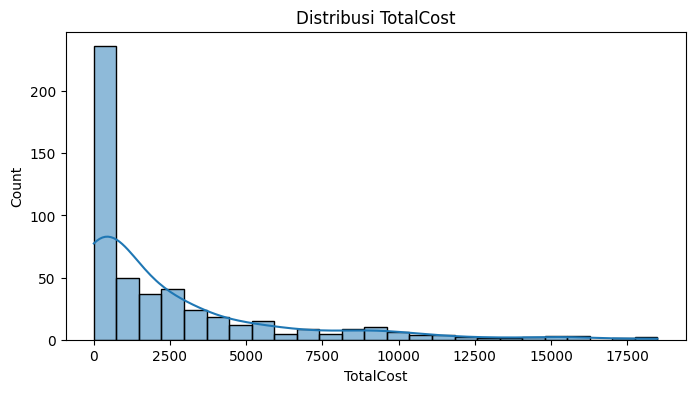

In [19]:
# Distribusi target
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalCost'], kde=True)
plt.title("Distribusi TotalCost")
plt.show()

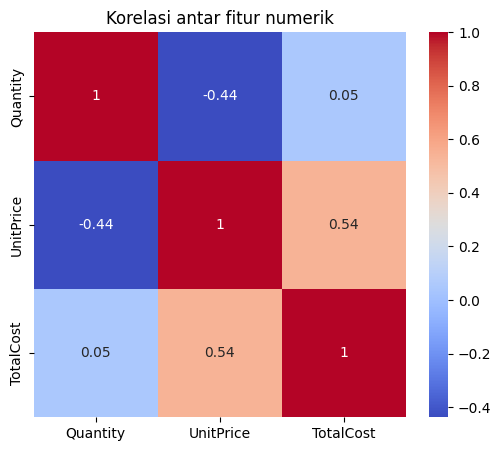

In [20]:
# Korelasi fitur numerik
plt.figure(figsize=(6, 5))
sns.heatmap(df[['Quantity', 'UnitPrice', 'TotalCost']].corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar fitur numerik")
plt.show()

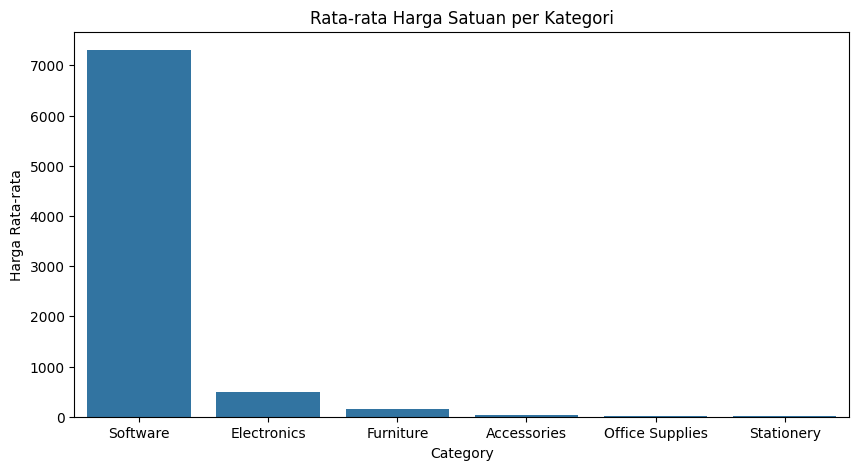

In [23]:
plt.figure(figsize=(10, 5))
avg_price = df.groupby('Category')['UnitPrice'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.title("Rata-rata Harga Satuan per Kategori")
plt.ylabel("Harga Rata-rata")
plt.xticks(rotation=0)
plt.show()

## 5. Data Preparation
- Encode data kategorikal
- Normalisasi fitur numerik
- Split data train/test

In [24]:
# Encode categorical features
cat_cols = ['Category', 'Supplier', 'Buyer']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [25]:
# Feature selection
features = ['Category', 'Quantity', 'UnitPrice', 'Supplier', 'Buyer']
X = df[features]
y = df['TotalCost']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 6. Modeling
Model: Random Forest Regressor

In [27]:
# Training model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 7. Evaluation
Evaluasi menggunakan metrik MAE, RMSE, dan R² Score.

In [28]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 135.65
RMSE: 326.99
R²: 0.99


Berikut hasil evaluasi model regresi menggunakan metrik MAE, RMSE, dan R²:

1. Mean Absolute Error (MAE): 135.65
- Rata-rata selisih absolut antara prediksi dan nilai aktual adalah sekitar 135. Artinya, model umumnya meleset ±135 satuan dalam memprediksi TotalCost.

2. Root Mean Squared Error (RMSE): 326.99
- Menunjukkan bahwa rata-rata kesalahan prediksi dalam satuan aslinya adalah sekitar 327, sedikit lebih sensitif terhadap outlier daripada MAE.

3. R² Score (Koefisien Determinasi): 0.99
- Model mampu menjelaskan 99% variasi dalam data target TotalCost. Ini menunjukkan performa yang sangat baik.

Secara keseluruhan, model memberikan performa prediksi yang sangat akurat berdasarkan data yang tersedia.

## 8. Kesimpulan
Model regresi mampu memprediksi total pengeluaran dengan cukup akurat degan hasil:

* Mean Absolute Error (MAE): 135.65
* Root Mean Squared Error (RMSE): 326.99
* R² Score (Koefisien Determinasi): 0.99

Saran Langkah selanjutnya:
- Coba model lain (Linear Regression, XGBoost)
- Tuning parameter
- Visualisasi hasil prediksi vs data asli